NIM : 22.11.5054
NIM : 22.11.5067

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Inisialisasi Spark Session
spark = SparkSession.builder.appName("Housing Price Prediction").getOrCreate()

# Memuat dataset
df = pd.read_csv("/content/drive/MyDrive/sem 5/AdvanceBigData/UAS/Housing.csv")

# Menampilkan 5 data awal
print("Pratinjau Dataset:")
print(df.head())

Pratinjau Dataset:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [6]:
df.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


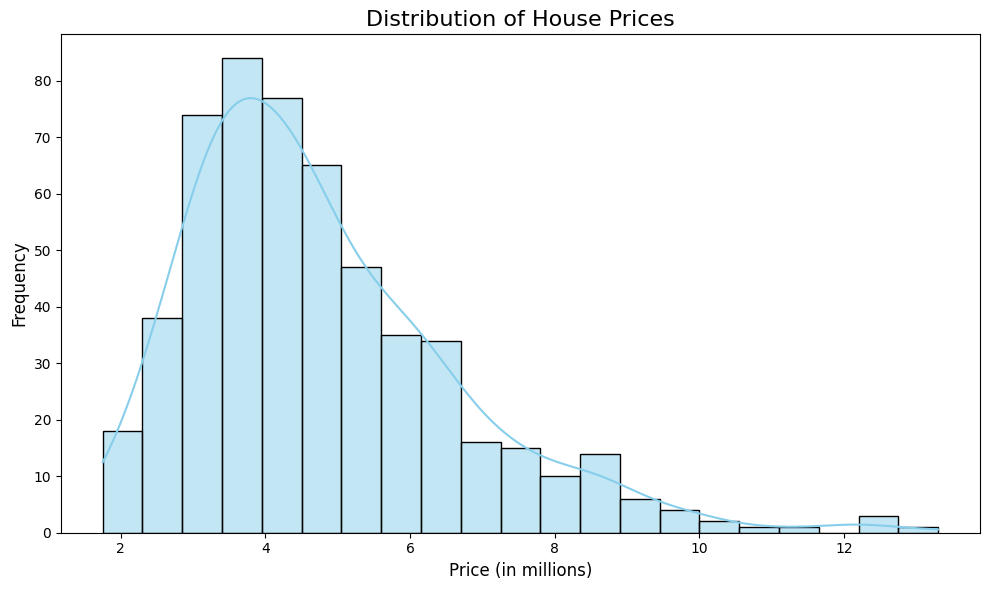

In [7]:
# Transforming price to millions for better readability
df['price_millions'] = df['price'] / 1e6

plt.figure(figsize=(10, 6))
sns.histplot(df['price_millions'], kde=True, color='skyblue', edgecolor='black')

plt.title('Distribution of House Prices', fontsize=16)
plt.xlabel('Price (in millions)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

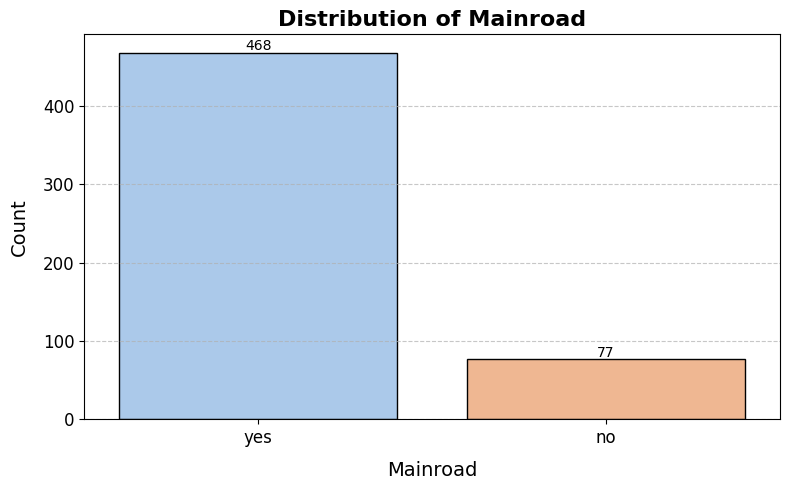

In [8]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['mainroad'], hue=df['mainroad'], palette='pastel', dodge=False, edgecolor='black', order=['yes', 'no'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Mainroad", fontsize=16, fontweight='bold')
plt.xlabel("Mainroad", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

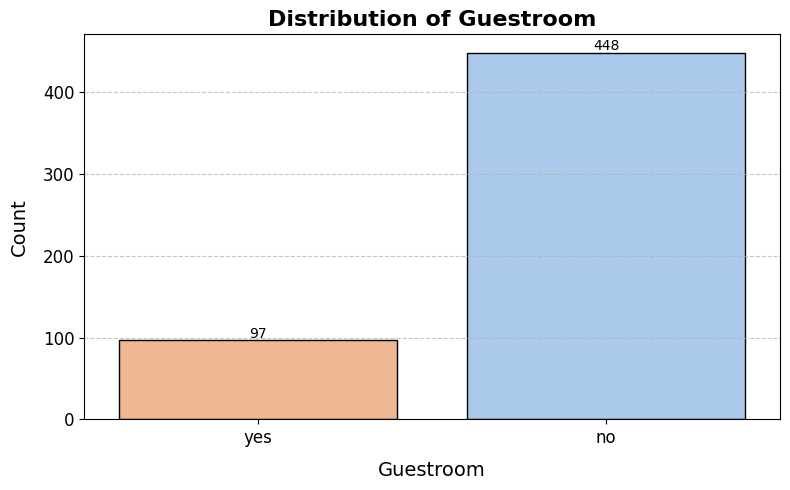

In [9]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['guestroom'], hue=df['guestroom'], palette='pastel', dodge=False, edgecolor='black', order=['yes', 'no'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Guestroom", fontsize=16, fontweight='bold')
plt.xlabel("Guestroom", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


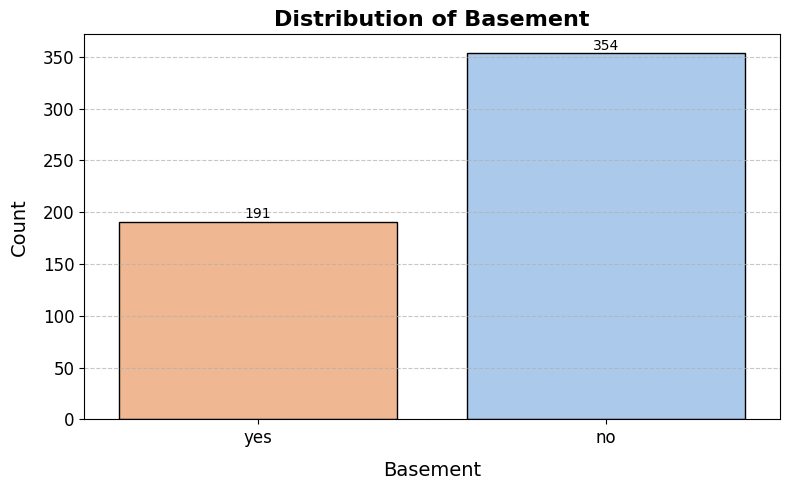

In [10]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['basement'], hue=df['basement'], palette='pastel', dodge=False, edgecolor='black', order=['yes', 'no'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Basement", fontsize=16, fontweight='bold')
plt.xlabel("Basement", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


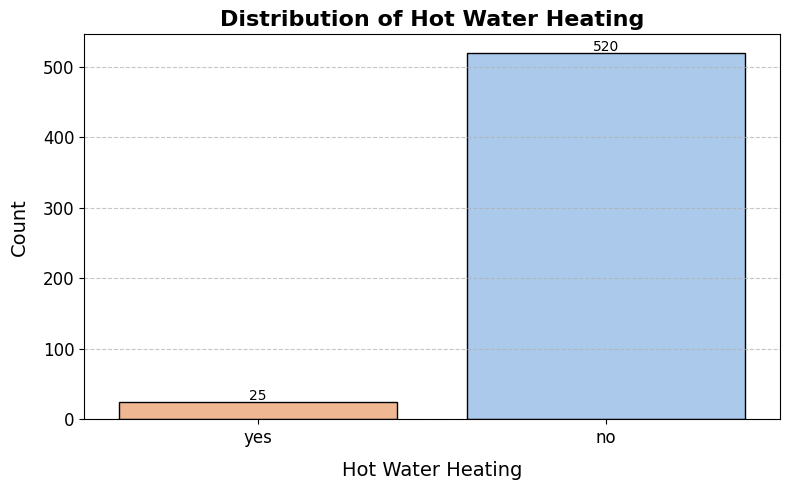

In [11]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['hotwaterheating'], hue=df['hotwaterheating'], palette='pastel', dodge=False, edgecolor='black', order=['yes', 'no'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Hot Water Heating", fontsize=16, fontweight='bold')
plt.xlabel("Hot Water Heating", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

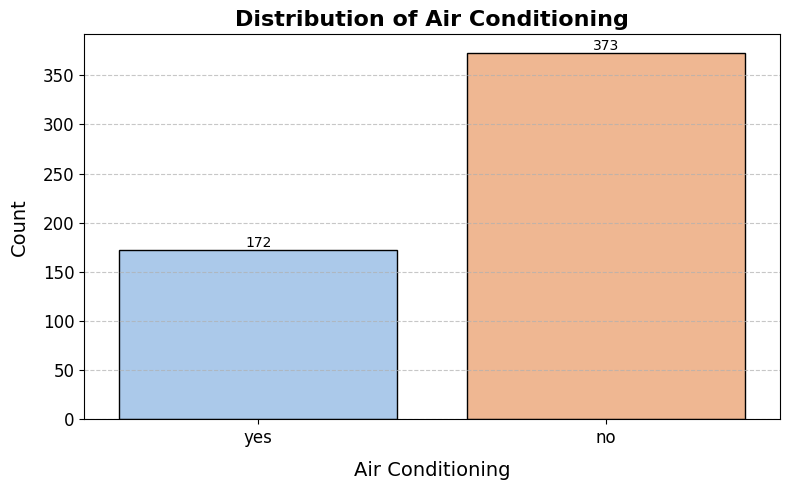

In [12]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['airconditioning'], hue=df['airconditioning'], palette='pastel', dodge=False, edgecolor='black', order=['yes', 'no'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Air Conditioning", fontsize=16, fontweight='bold')
plt.xlabel("Air Conditioning", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

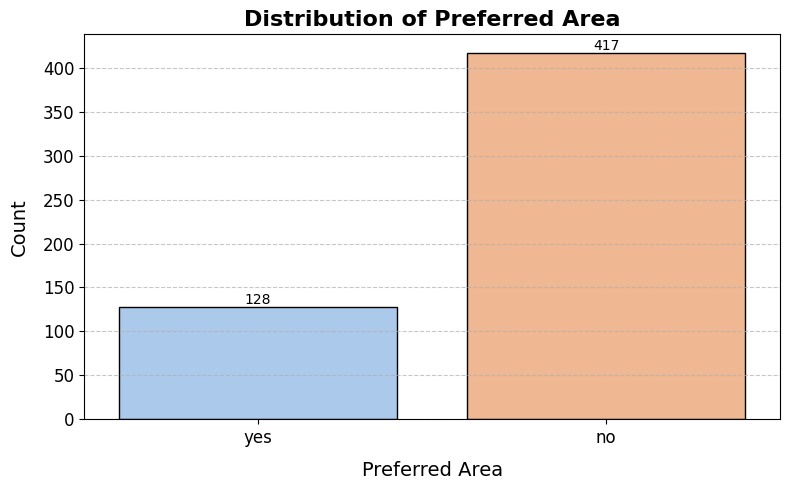

In [13]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['prefarea'], hue=df['prefarea'], palette='pastel', dodge=False, edgecolor='black', order=['yes', 'no'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Preferred Area", fontsize=16, fontweight='bold')
plt.xlabel("Preferred Area", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


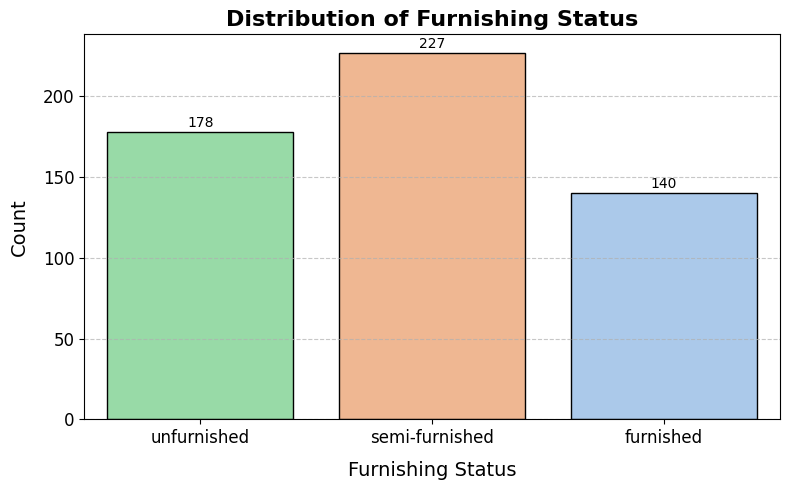

In [14]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['furnishingstatus'], hue=df['furnishingstatus'], palette='pastel', dodge=False, edgecolor='black', order=['unfurnished', 'semi-furnished', 'furnished'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Furnishing Status", fontsize=16, fontweight='bold')
plt.xlabel("Furnishing Status", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

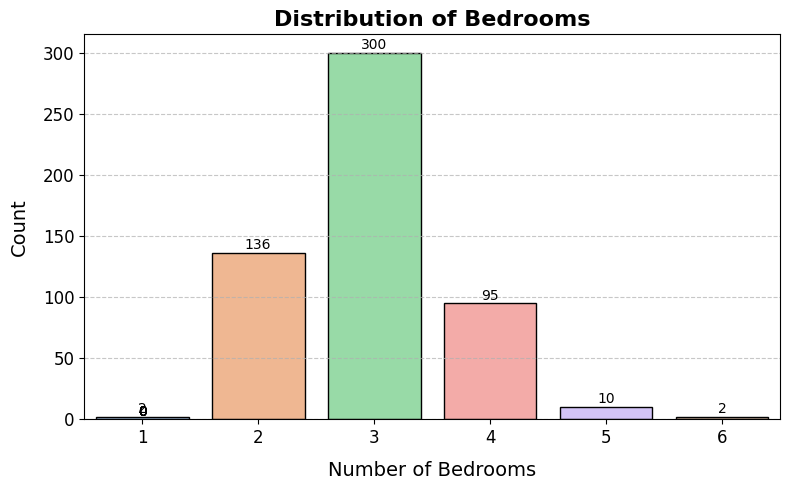

In [15]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['bedrooms'], hue=df['bedrooms'], palette='pastel', dodge=False, edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Bedrooms", fontsize=16, fontweight='bold')
plt.xlabel("Number of Bedrooms", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


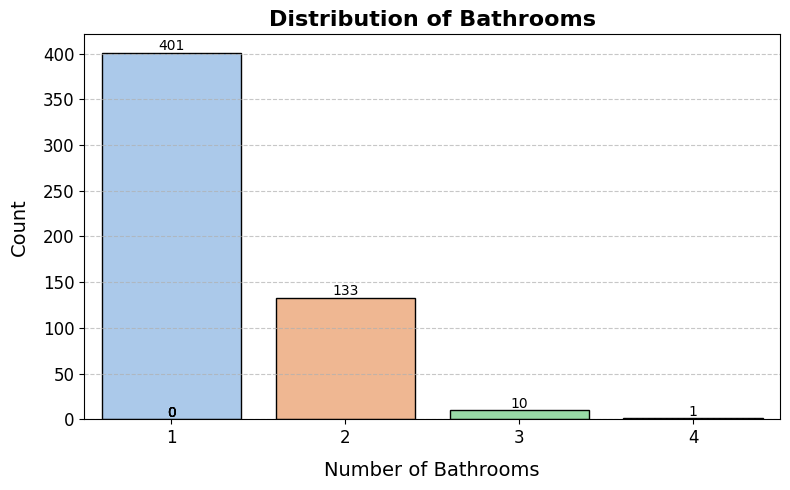

In [16]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['bathrooms'], hue=df['bathrooms'], palette='pastel', dodge=False, edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Bathrooms", fontsize=16, fontweight='bold')
plt.xlabel("Number of Bathrooms", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

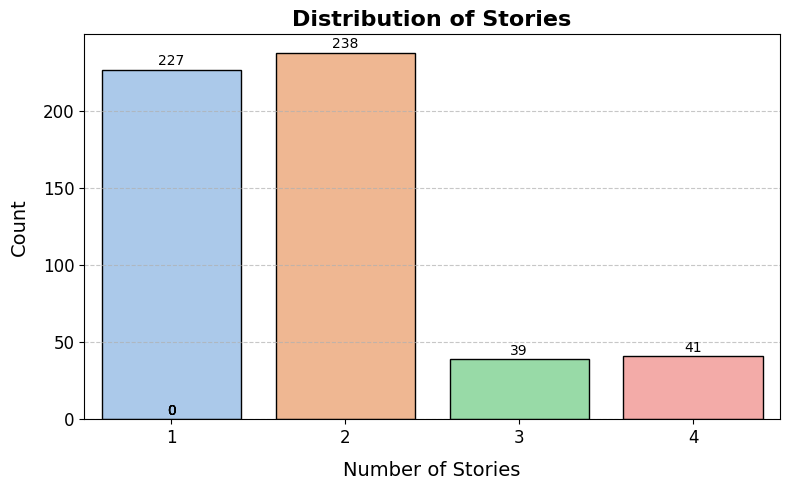

In [17]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['stories'], hue=df['stories'], palette='pastel', dodge=False, edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Stories", fontsize=16, fontweight='bold')
plt.xlabel("Number of Stories", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


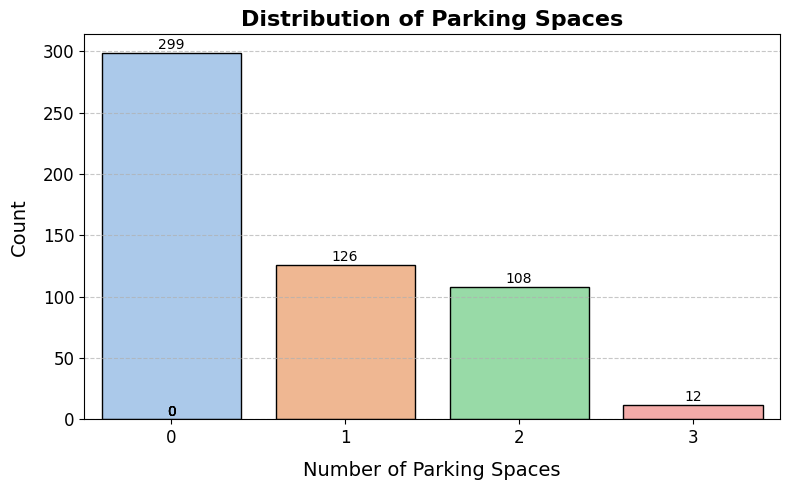

In [18]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['parking'], hue=df['parking'], palette='pastel', dodge=False, edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 3),
                ha='center', fontsize=10)

plt.title("Distribution of Parking Spaces", fontsize=16, fontweight='bold')
plt.xlabel("Number of Parking Spaces", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

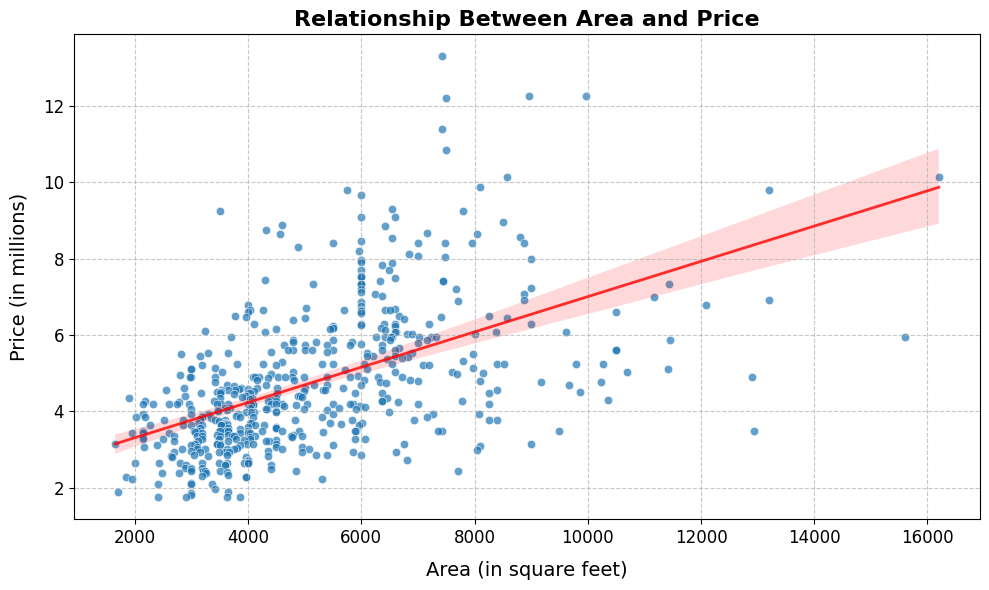

In [19]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=df['area'], y=df['price_millions'], alpha=0.7, edgecolor='w')

sns.regplot(x=df['area'], y=df['price_millions'], scatter=False, color='red', line_kws={'linewidth': 2, 'alpha': 0.8})

plt.title("Relationship Between Area and Price", fontsize=16, fontweight='bold')
plt.xlabel("Area (in square feet)", fontsize=14, labelpad=10)
plt.ylabel("Price (in millions)", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


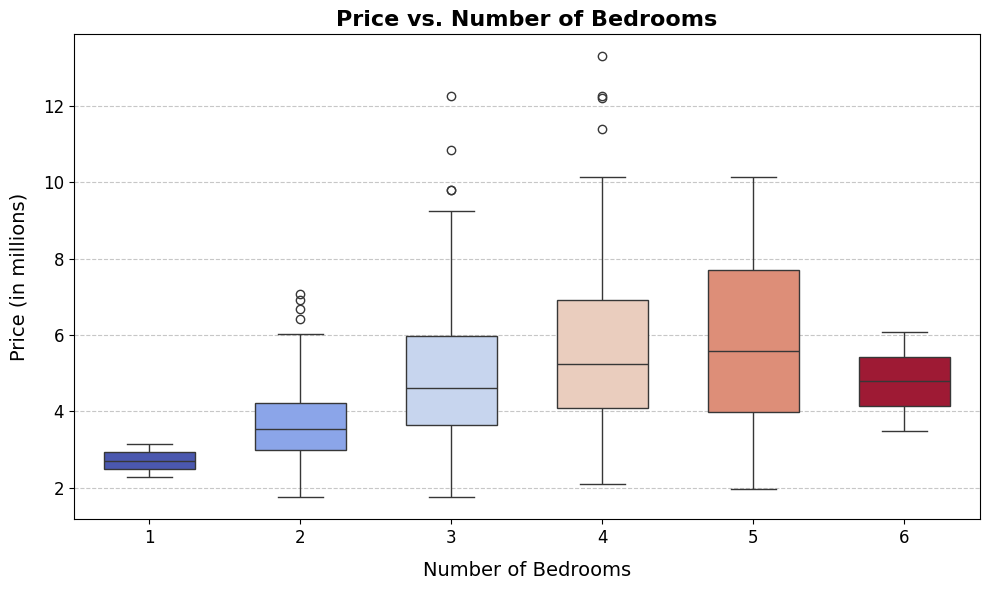

In [20]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=df['bedrooms'], y=df['price_millions'], hue=df['bedrooms'], dodge=False, width=0.6, palette='coolwarm')

plt.title("Price vs. Number of Bedrooms", fontsize=16, fontweight='bold')
plt.xlabel("Number of Bedrooms", fontsize=14, labelpad=10)
plt.ylabel("Price (in millions)", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend([], [], frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

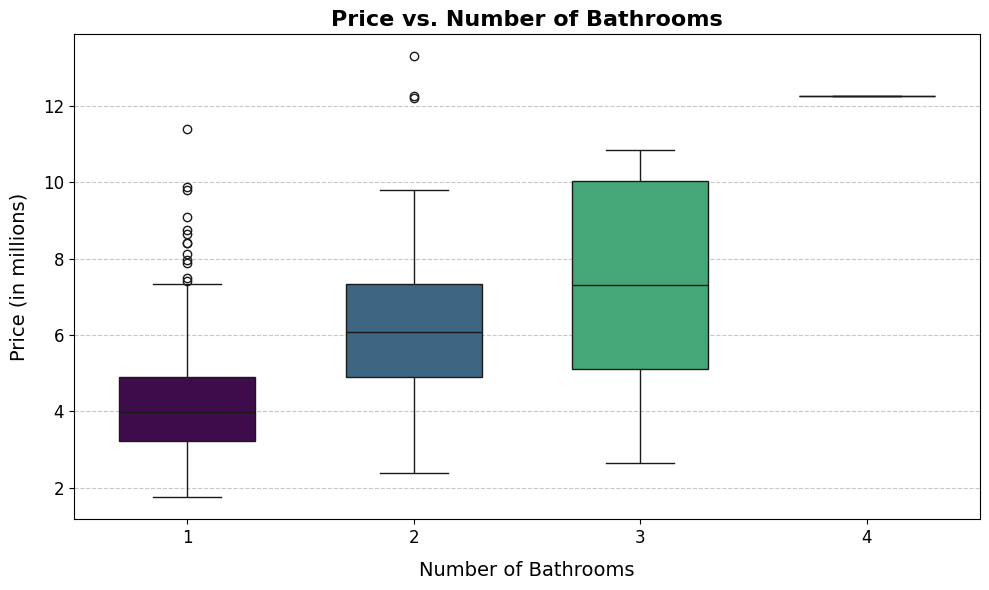

In [21]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=df['bathrooms'], y=df['price_millions'], hue=df['bathrooms'], dodge=False, width=0.6, palette='viridis')

plt.title("Price vs. Number of Bathrooms", fontsize=16, fontweight='bold')
plt.xlabel("Number of Bathrooms", fontsize=14, labelpad=10)
plt.ylabel("Price (in millions)", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend([], [], frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

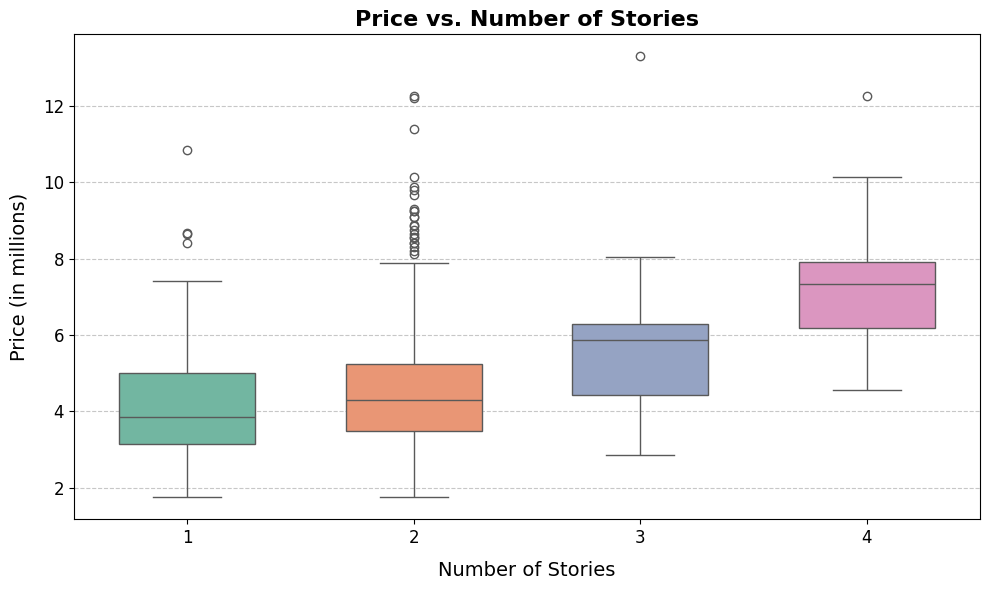

In [22]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=df['stories'], y=df['price_millions'], hue=df['stories'], dodge=False, width=0.6, palette='Set2')

plt.title("Price vs. Number of Stories", fontsize=16, fontweight='bold')
plt.xlabel("Number of Stories", fontsize=14, labelpad=10)
plt.ylabel("Price (in millions)", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend([], [], frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

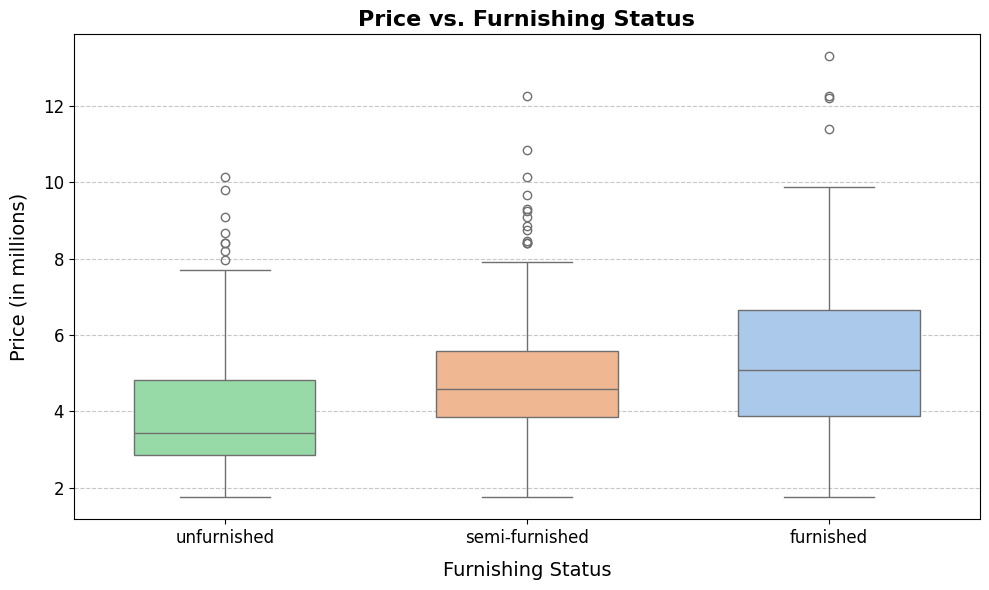

In [23]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    x=df['furnishingstatus'],
    y=df['price_millions'],
    hue=df['furnishingstatus'],
    dodge=False,
    width=0.6,
    palette='pastel',
    order=['unfurnished', 'semi-furnished', 'furnished']
)

plt.title("Price vs. Furnishing Status", fontsize=16, fontweight='bold')
plt.xlabel("Furnishing Status", fontsize=14, labelpad=10)
plt.ylabel("Price (in millions)", fontsize=14, labelpad=10)

plt.legend([], [], frameon=False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

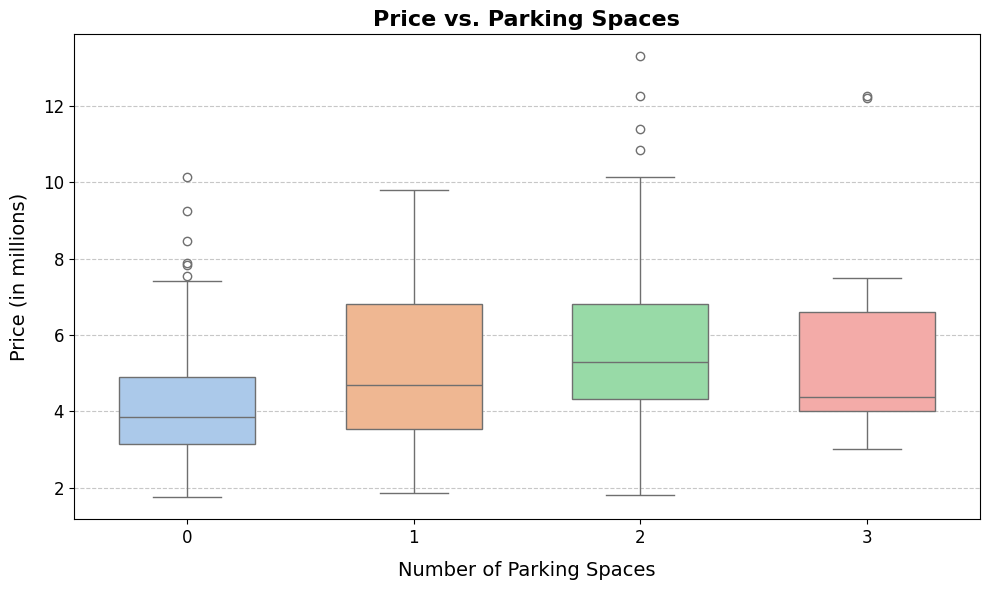

In [24]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    x=df['parking'],
    y=df['price_millions'],
    hue=df['parking'],
    dodge=False,
    width=0.6,
    palette='pastel'
)

plt.title("Price vs. Parking Spaces", fontsize=16, fontweight='bold')
plt.xlabel("Number of Parking Spaces", fontsize=14, labelpad=10)
plt.ylabel("Price (in millions)", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

# **DATA PREPROCESSING**

In [25]:
encoder = LabelEncoder()

encoding_col = ['furnishingstatus', 'prefarea', 'airconditioning',
                'hotwaterheating', 'basement', 'guestroom', 'mainroad']

for col in encoding_col:
    df[col] = encoder.fit_transform(df[col])

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_millions
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,13.300
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,12.250
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,12.250
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,12.215
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,11.410


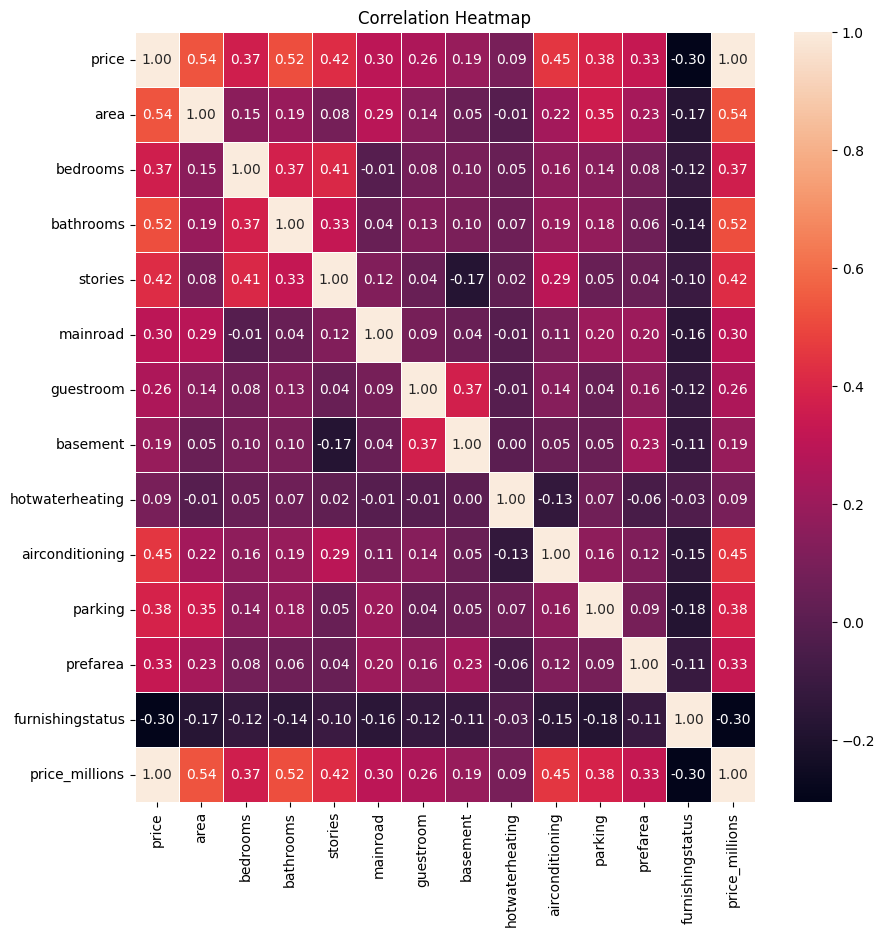

In [26]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [27]:
# Dropping 'price' since we are using 'price_millions'
df = df.drop(columns=['price'], axis=1)

X = df.drop(columns=['price_millions'], axis=1)
y = df['price_millions']


In [28]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

y = scaler.fit_transform(y.values.reshape(-1, 1))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# MACHINE LEARNING MODELS

lINEAR REGRESION

In [30]:
ln_model = LinearRegression()
ln_model.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred = ln_model.predict(X_test)

ln_r2 = r2_score(y_test, y_pred)
ln_mae = mean_absolute_error(y_test, y_pred)
ln_mse = mean_squared_error(y_test, y_pred)
ln_rmse = np.sqrt(ln_mse)

print("Linear Regression Metrics:")
print("R² Score:", ln_r2)
print("Mean Absolute Error (MAE):", ln_mae)
print("Mean Squared Error (MSE):", ln_mse)
print("Root Mean Squared Error (RMSE):", ln_rmse)

Linear Regression Metrics:
R² Score: 0.7624579467323473
Mean Absolute Error (MAE): 0.06332171625253744
Mean Squared Error (MSE): 0.006055724882518721
Root Mean Squared Error (RMSE): 0.07781853816744902


Decision Tree Regressor

In [32]:
dt_model = DecisionTreeRegressor(random_state=50)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=50)

In [33]:
y_pred = dt_model.predict(X_test)

dt_r2 = r2_score(y_test, y_pred)
dt_mae = mean_absolute_error(y_test, y_pred)
dt_mse = mean_squared_error(y_test, y_pred)
dt_rmse = np.sqrt(dt_mse)

print("Decision Tree Metrics:")
print("R² Score:", dt_r2)
print("Mean Absolute Error (MAE):", dt_mae)
print("Mean Squared Error (MSE):", dt_mse)
print("Root Mean Squared Error (RMSE):", dt_rmse)

Decision Tree Metrics:
R² Score: 0.1412462288809122
Mean Absolute Error (MAE): 0.10237125382262995
Mean Squared Error (MSE): 0.021892446024549074
Root Mean Squared Error (RMSE): 0.14796096115039628


Random Forest Regressor

In [34]:
# Hyper tuning the model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=50),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train.ravel())

best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters for Random Forest:", grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [35]:
y_pred = best_rf_model.predict(X_test)

In [36]:
rf_r2 = r2_score(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)

print("\nTuned Random Forest Metrics:")
print("R² Score:", rf_r2)
print("Mean Absolute Error (MAE):", rf_mae)
print("Mean Squared Error (MSE):", rf_mse)
print("Root Mean Squared Error (RMSE):", rf_rmse)


Tuned Random Forest Metrics:
R² Score: 0.7627798978885525
Mean Absolute Error (MAE): 0.05992371999639104
Mean Squared Error (MSE): 0.006047517293164468
Root Mean Squared Error (RMSE): 0.07776578484889397
